In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_percentage_error, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

import shap

In [2]:
data = pd.read_csv('dataset.csv')
data.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Почистим данные от пропусков  🧹🦆

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
data['Gender'] = data['Gender'].fillna('Male')
data['Married'] = data['Married'].fillna('Yes')
data['Dependents'] = data['Dependents'].fillna('0')
data['Self_Employed'] = data['Self_Employed'].fillna('No')
data['LoanAmount'] = data['LoanAmount'].fillna(150)
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(360)
data['Credit_History'] = data['Credit_History'].fillna(1)

In [5]:
data = pd.get_dummies(data, columns=['Gender', 'Married','Dependents', 'Education','Self_Employed','Property_Area','Loan_Status'], drop_first = True)
data.head(1)

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,LP001002,5849,0.0,150.0,360.0,1.0,True,False,False,False,False,False,False,False,True,True


In [6]:
y = data['Loan_Status_Y']
data = data.drop(['Loan_Status_Y','Loan_ID'], axis = 1)

## Обучим логистическую регрессию, подберем пороги и проанализируем результаты

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 42)
# Нормализация данных
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression() #создание модели
model.fit(x_train, y_train) #обучение на тренировочном наборе

# Получение вероятностей предсказаний
y_pred_proba = model.predict_proba(x_test)[:, 1]  # Вероятности положительного класса

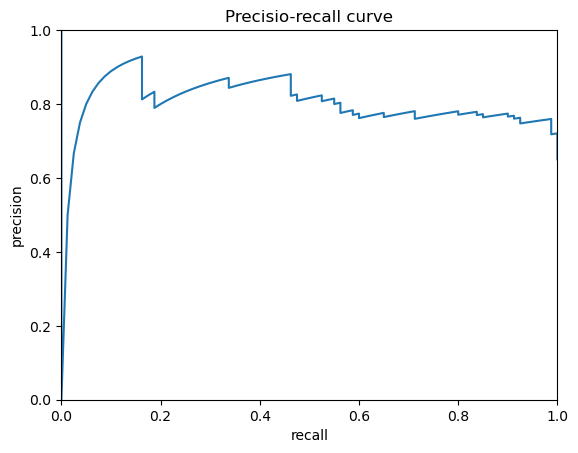

In [8]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision, label = 'Precisio-recall curve')
plt.title('Precisio-recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

#### Попробуем разные пороги

In [9]:
threshold = 0.84
y_pred = (y_pred_proba >= threshold).astype(int)

# Оценка модели
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {roc_auc}')

precision = precision_score(y_test, y_pred)
print(f'Precision с порогом: {precision}')

recall = recall_score(y_test, y_pred)
print(f'Recall с порогом: {recall}')

good_model = model

AUC-ROC: 0.75
Precision с порогом: 0.8409090909090909
Recall с порогом: 0.4625


In [10]:
threshold = 0.11
y_pred = (y_pred_proba >= threshold).astype(int)

# Оценка модели
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {roc_auc}')

precision = precision_score(y_test, y_pred)
print(f'Precision с порогом: {precision}')

recall = recall_score(y_test, y_pred)
print(f'Recall с порогом: {recall}')

AUC-ROC: 0.75
Precision с порогом: 0.7207207207207207
Recall с порогом: 1.0


#### Нашли пороги, при которых достигается максимальное значение precision и recall.
С первым порогом вопросов не возникает, примерно 84% людей вернут кредиты, что неплохо, однако поймать мы смогли только 46% из общего количества.

Во втором случае мы выдаем кредиты почти что всем людям, совершенно логично, что мы находим всех тех, кто вернет кредит, однако, также мы натыкаемся на плохих заемщиков. Почему же тогда точность такая высокая? Все очень просто - по статистике примерно 70% людей возвращают кредиты. Данный порог может показаться весьма сомнительным, однако, по графику видно, что для recall от 0.5 до 1 precision практически не меняется. Если издержки при невозвратах не очень велики, то, возможно, действительно неплохим решением будет выдавать кредиты почти всем желающим. На стороне этого довода и модель и статистика

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 42)

model = LogisticRegression() #создание модели
model.fit(x_train, y_train) #обучение на тренировочном наборе

# Получение вероятностей предсказаний
y_pred_proba = model.predict_proba(x_test)[:, 1]  # Вероятности положительного класса

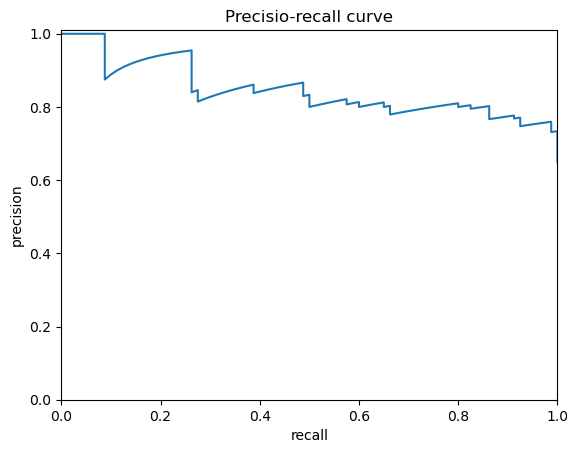

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision, label = 'Precisio-recall curve')
plt.title('Precisio-recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

In [13]:
threshold = 0.86
y_pred = (y_pred_proba >= threshold).astype(int)

# Оценка модели
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {roc_auc}')

precision = precision_score(y_test, y_pred)
print(f'Precision с порогом: {precision}')

recall = recall_score(y_test, y_pred)
print(f'Recall с порогом: {recall}')

AUC-ROC: 0.7761627906976745
Precision с порогом: 0.9523809523809523
Recall с порогом: 0.25


### Сравним 2 модели 
Вторая модель (данные не были нормализованы) получила более хороший результат по метрике precision - на целых 10% больше! По recall лучший показатель примерно такой же, как и у первой модели. Мы все еще видим, что прри изменении recall от 0.5 до 1.0 точность почти никак не изменяется.

Может показаться, что вторая модель лучше, но не стоит торопиться. У второй модели высокая точность, но ужасно низкий recall - всего 0.25. 

Можем прикинуть, что из сотни подающихся примерно 70 человек смогут расплатиться по долгам. Первая модель одобрит кредит 42 людям, а вот вторая всего лишь 24-м. Различия весьма существенные, хотя во втором случае мы почти наверняка знаем, что кредит вернут, тем не менее, мы упускаем почти половину возможностей. Безусловно, на практике бывают случаи, когда каждый банкрот очень больно ударяет по доходам банка, но в случае с микрокредитной организацией такого, скорее всего, ожидать не следует

## Оценим важность признаков

In [14]:
good_model.coef_

array([[-0.01765927, -0.16041852, -0.16962475,  0.01360042,  1.34015587,
        -0.03538027,  0.32746236, -0.18595577,  0.11748895,  0.13305214,
        -0.14412974,  0.04659394,  0.47476662,  0.124522  ]])

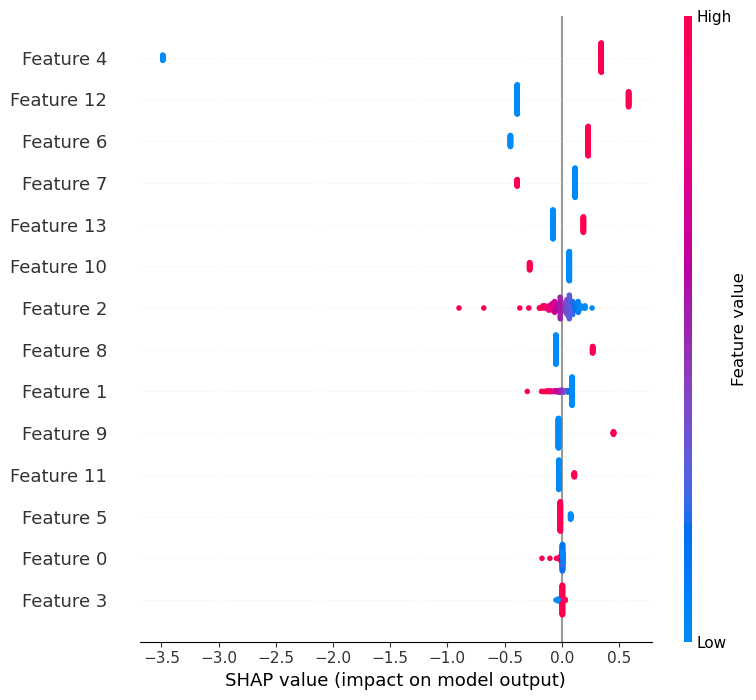

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 42)
# Нормализация данных
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression() #создание модели
model.fit(x_train, y_train) #обучение на тренировочном наборe

explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_test)

# Визуализация важности признаков
shap.summary_plot(shap_values, x_test)

Видно, что наиболее важными признаками являются: наличие кредитной истории, проживание в полугородской среде и нахождение в браке. То есть, идеальный кандидат на выдачу кредита - знакомый банку клиент, находящийся в браке и проживающий за городом в поселке. 

Это подтверждается и коэффициентами логистической регрессии

## Посмотрим на разных, придуманных клиентов 

In [16]:
example_data = {
'ApplicantIncome': 	[3000],
'CoapplicantIncome': [500],
'LoanAmount': [100],
'Loan_Amount_Term': [360],
'Credit_History': [1],
'Gender_Male': [1],
'Married_Yes': [1],
'Dependents_1':	[0],
'Dependents_2': [0],
'Dependents_3+': [1],
'Education_Not Graduate': [1],
'Self_Employed_Yes': [1],
'Property_Area_Semiurban': [1],	
'Property_Area_Urban': [0]
}

example_df = pd.DataFrame(example_data)
example_df = scaler.transform(example_df)

y_pred_proba = good_model.predict_proba(example_df)[:, 1] 
print(y_pred_proba)

[0.93715074]


In [17]:
example_data = {
'ApplicantIncome': 	[3000],
'CoapplicantIncome': [500],
'LoanAmount': [100],
'Loan_Amount_Term': [360],
'Credit_History': [1],
'Gender_Male': [0],
'Married_Yes': [1],
'Dependents_1':	[0],
'Dependents_2': [0],
'Dependents_3+': [1],
'Education_Not Graduate': [1],
'Self_Employed_Yes': [1],
'Property_Area_Semiurban': [1],	
'Property_Area_Urban': [0]
}

example_df = pd.DataFrame(example_data)
example_df = scaler.transform(example_df)

y_pred_proba = good_model.predict_proba(example_df)[:, 1] 
print(y_pred_proba)

[0.94226371]


Типичный житель дачного поселка, у которого есть семья. Ему модель отдает наибольшее предпочтение. 

Удивительный факт: женщины для модели немного более предпочтительны, чем мужчины. Но разница невелика, так что, как мы и выясняли в ноутбуке с анализом, оба пола равнозначны

In [18]:
example_data = {
'ApplicantIncome': 	[3000],
'CoapplicantIncome': [500],
'LoanAmount': [100],
'Loan_Amount_Term': [360],
'Credit_History': [1],
'Gender_Male': [0],
'Married_Yes': [0],
'Dependents_1':	[0],
'Dependents_2': [0],
'Dependents_3+': [0],
'Education_Not Graduate': [1],
'Self_Employed_Yes': [1],
'Property_Area_Semiurban': [1],	
'Property_Area_Urban': [0]
}

example_df = pd.DataFrame(example_data)
example_df = scaler.transform(example_df)

y_pred_proba = good_model.predict_proba(example_df)[:, 1] 
print(y_pred_proba)

[0.83631794]


Если человек не имеет семьи, тогда вероятность того, что он вернет кредит, уменьшается. Но не слишком критично

In [19]:
example_data = {
'ApplicantIncome': 	[3000],
'CoapplicantIncome': [0],
'LoanAmount': [10],
'Loan_Amount_Term': [360],
'Credit_History': [0],
'Gender_Male': [0],
'Married_Yes': [1],
'Dependents_1':	[0],
'Dependents_2': [0],
'Dependents_3+': [1],
'Education_Not Graduate': [1],
'Self_Employed_Yes': [1],
'Property_Area_Semiurban': [1],	
'Property_Area_Urban': [0]
}

example_df = pd.DataFrame(example_data)

example_df = scaler.transform(example_df)


y_pred_proba = good_model.predict_proba(example_df)[:, 1]  
print(y_pred_proba)

[0.30189825]


А вот отсутствие кредитной истории моделью вопринимается крайне негативно, проседание более чем на 50%

In [20]:
example_data = {
'ApplicantIncome': 	[1000],
'CoapplicantIncome': [100],
'LoanAmount': [50],
'Loan_Amount_Term': [600],
'Credit_History': [0],
'Gender_Male': [0],
'Married_Yes': [1],
'Dependents_1':	[0],
'Dependents_2': [0],
'Dependents_3+': [1],
'Education_Not Graduate': [0],
'Self_Employed_Yes': [1],
'Property_Area_Semiurban': [1],	
'Property_Area_Urban': [0]
}

example_df = pd.DataFrame(example_data)
example_df = scaler.transform(example_df)

y_pred_proba = good_model.predict_proba(example_df)[:, 1]  
print(y_pred_proba)

[0.37274098]


Наилучший результат у незнакомого для банка человека - 37% доверия от модели. Жестоко ли это? Да, безусловно. 

Плохая ли модель? Нет, модель как раз-таки хорошая, потому что 90% берущих кредит впервые не получают его. Соответственно, модель, можно так даже сказать, очень хорошо принимает во внимание положительные стороны кандидата. 

Если бы было больше данных, то можно было бы крутую модель, которая бы предсказывала бы, кто из новых клиентов скорее вернет кредит, а кто не вернет, но, увы, данных по новым клиентам всего 100 штук, тем более у нас еще и жесткий дизбаланс классов, правильных ответов (кому надо одобрить кредит) раз два и обчелся. 

In [21]:
example_data = {
'ApplicantIncome': 	[1000],
'CoapplicantIncome': [100],
'LoanAmount': [500],
'Loan_Amount_Term': [360],
'Credit_History': [1],
'Gender_Male': [1],
'Married_Yes': [0],
'Dependents_1':	[1],
'Dependents_2': [0],
'Dependents_3+': [0],
'Education_Not Graduate': [1],
'Self_Employed_Yes': [0],
'Property_Area_Semiurban': [0],	
'Property_Area_Urban': [0]
}

example_df = pd.DataFrame(example_data)
example_df = scaler.transform(example_df)

y_pred_proba = good_model.predict_proba(example_df)[:, 1] 
print(y_pred_proba)

[0.30239179]


Отметим, что данный отсутствие кредитной истории - не приговор

Хоть остальные признаки не так колоссально влияют на ответ модели, в совокупности слишком большой размер кредита, наличие ровно 1 ребенка, отсутствие статуса самозанятого и проживание в деревне может очень сильно снизить вероятность выдачи кредита. 

Выше представлен наихудший клиент, который при этом всем имеет кредитную историю, но которому скорее следует отказать в займе

### А вообще, давайте все-таки попробуем!

In [22]:
data = pd.read_csv('dataset.csv')
data['Gender'] = data['Gender'].fillna('Male')
data['Married'] = data['Married'].fillna('Yes')
data['Dependents'] = data['Dependents'].fillna('0')
data['Self_Employed'] = data['Self_Employed'].fillna('No')
data['LoanAmount'] = data['LoanAmount'].fillna(150)
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(360)
data['Credit_History'] = data['Credit_History'].fillna(1)

data = pd.get_dummies(data, columns=['Gender', 'Married','Dependents', 'Education','Self_Employed','Property_Area','Loan_Status'], drop_first = True)


data_ = data[data['Credit_History'] == 1.0]

y = data_['Loan_Status_Y']
data_ = data_.drop(['Loan_Status_Y','Loan_ID'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(data_, y, test_size = 0.3, random_state = 200)
# Нормализация данных
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression() #создание модели
model.fit(x_train, y_train) #обучение на тренировочном наборе

# Получение вероятностей предсказаний
y_pred_proba = model.predict_proba(x_test)[:, 1]  # Вероятности положительного класса

In [23]:
threshold = 0.81
y_pred = (y_pred_proba >= threshold).astype(int)

# Оценка модели
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {roc_auc}')

precision = precision_score(y_test, y_pred)
print(f'Precision с порогом: {precision}')

recall = recall_score(y_test, y_pred)
print(f'Recall с порогом: {recall}')

AUC-ROC: 0.6259487666034156
Precision с порогом: 0.8533333333333334
Recall с порогом: 0.5161290322580645


##### О! Что-то неплохое получилось! 

По прикидкам получается, что мы ловим ровно половину из тех, кто мог бы вернуть нам кредит, но при этом 85% из тех, кому мы одобряем кредит, его вернут (работник банка бы одобрил его). Соответственно, в нашем случае получается, что, условно, из сотни кандидатов мы отобрали 7 и 6 из них вернут нам кредит. 

Результат классный, потому что предыдущая модель обращала на них сильно меньше внимания и, чтобы учесть таких кандидатов, приходилось ставить низкий порог и жертвовать точностью. Теперь же мы можем использовать 2 модели для более четкой и чуткой выдачи кредитов!

Как говорил кот Матроскин: "У меня теперь две коровы есть!" 
# 🐄🐄

## Проанализируем результаты

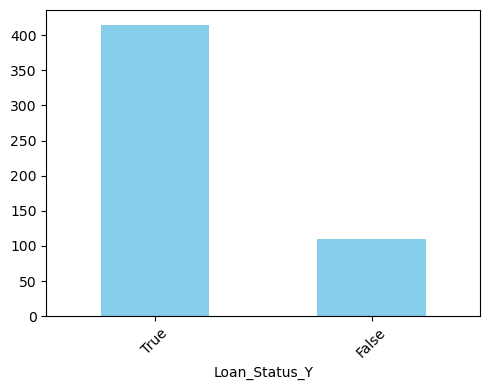

In [24]:
data = pd.read_csv('dataset.csv')

data['Gender'] = data['Gender'].fillna('Male')
data['Married'] = data['Married'].fillna('Yes')
data['Dependents'] = data['Dependents'].fillna('0')
data['Self_Employed'] = data['Self_Employed'].fillna('No')
data['LoanAmount'] = data['LoanAmount'].fillna(150)
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(360)
data['Credit_History'] = data['Credit_History'].fillna(1)

data = pd.get_dummies(data, columns=['Gender', 'Married','Dependents', 'Education','Self_Employed','Property_Area','Loan_Status'], drop_first = True)
data.head(1)

data_ = data[data['Credit_History'] == 1]

genre_counts = data_['Loan_Status_Y'].value_counts()
plt.figure(figsize = (5, 4))  
genre_counts.plot(kind = 'bar', color = 'skyblue')
plt.xticks(rotation = 45)  
plt.tight_layout() 
plt.show()

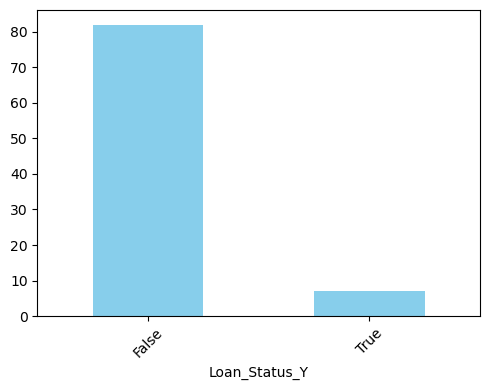

In [25]:
data_ = data[data['Credit_History'] == 0]

genre_counts = data_['Loan_Status_Y'].value_counts()
plt.figure(figsize = (5, 4))  
genre_counts.plot(kind = 'bar', color = 'skyblue')
plt.xticks(rotation = 45)  
plt.tight_layout() 
plt.show()

Как видно по графикам, те, кому банк выдал кредит впервые, с вероятностью в 90% не возвращают кредит. Неудивительно, что модель отдает такое предпочтение данному показателю.

Другие данные не так сильно влияют на результат, но, тем не менее, все равно являются важными для модели.

## Подведем итоги для логистической регрессии

Данную модель можно успешно использовать на реальных заемщиках, потому что её будет очень легко истрактовать:

Наличие кредитной истории крайне важно для модели

Жить по мнению модели лучше всего за городом, но не в деревне! При этом городскую среду она тоже считает подходящей, но не отдает ей большого предпочтения

Сумма займа может быть слишком большой

Число детей так же очень важно, по статистике бездетные и многодетные чаще возвращают кредиты, чем люди, имеющие только одного ребенка

С женатыми аналогичная ситуация

По мнению модели также лучше иметь какой-нибудь малый бизнес (быть самозанятым)

Использовать лучше 2 разных модели: для тех, у кого есть кредитная история и для тех, у кого её нет. Прирост будет небольшим, но, все равно приятным

Если возникают какие-то вопросы по поводу одобрения кредита - сотрудники банка могут сослаться на статистику и важность вышеперечисленных показателей



## Посмотрим, что скажет нам дерево

In [26]:
data = pd.read_csv('dataset.csv')
data.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [27]:
data['Gender'] = data['Gender'].fillna('Male')
data['Married'] = data['Married'].fillna('Yes')
data['Dependents'] = data['Dependents'].fillna('0')
data['Self_Employed'] = data['Self_Employed'].fillna('No')
data['LoanAmount'] = data['LoanAmount'].fillna(150)
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(360)
data['Credit_History'] = data['Credit_History'].fillna(1)

data = pd.get_dummies(data, columns=['Gender', 'Married','Dependents', 'Education','Self_Employed','Property_Area','Loan_Status'], drop_first = True)
#data.head(1)

y = data['Loan_Status_Y']
data = data.drop(['Loan_Status_Y','Loan_ID'], axis = 1)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state = 14)

model2 = DecisionTreeClassifier(max_depth = 3)
model2.fit(x_train, y_train) 
y_pred_proba = model2.predict_proba(x_test)[:, 1]
print(roc_auc_score(y_test, y_pred_proba))

0.7674403356936794


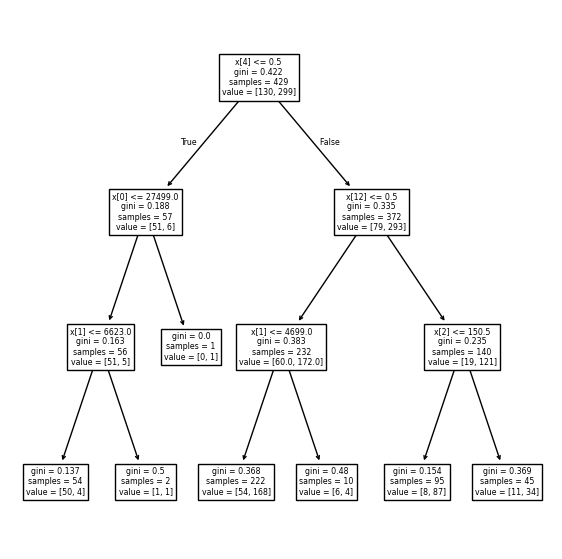

In [29]:
plt.figure(figsize=(7, 7))
a=plot_tree(model2)

In [30]:
data.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,150.0,360.0,1.0,True,False,False,False,False,False,False,False,True
1,4583,1508.0,128.0,360.0,1.0,True,True,True,False,False,False,False,False,False
2,3000,0.0,66.0,360.0,1.0,True,True,False,False,False,False,True,False,True
3,2583,2358.0,120.0,360.0,1.0,True,True,False,False,False,True,False,False,True
4,6000,0.0,141.0,360.0,1.0,True,False,False,False,False,False,False,False,True


Видно, что основное деление дерево проводит по наличию кредитной истории, а также пытается учесть заработную плату и место проживания. Результат в 78% в целом вполне не плох. Трактовка решения модели весьма простая - если есть кредитная история, то скорее всего кандидат нам подходит. Если же нет, то нужно учесть еще его место проживания. 

## Случайный лес

In [31]:
data = pd.read_csv('dataset.csv')

data['Gender'] = data['Gender'].fillna('Male')
data['Married'] = data['Married'].fillna('Yes')
data['Dependents'] = data['Dependents'].fillna('0')
data['Self_Employed'] = data['Self_Employed'].fillna('No')
data['LoanAmount'] = data['LoanAmount'].fillna(150)
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(360)
data['Credit_History'] = data['Credit_History'].fillna(1)

data = pd.get_dummies(data, columns=['Gender', 'Married','Dependents', 'Education','Self_Employed','Property_Area','Loan_Status'], drop_first = True)
#data.head(1)

y = data['Loan_Status_Y']
data = data.drop(['Loan_Status_Y','Loan_ID'], axis = 1)



x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state = 6)
model3 = RandomForestClassifier(n_estimators = 90, max_depth = 3)
model3.fit(x_train, y_train)

# Предсказание вероятностей для ROC AUC
y_pred_proba = model3.predict_proba(x_test)[:, 1]
print(roc_auc_score(y_test, y_pred_proba))

0.7898163377192983


Случайный лес учитывает мнение множества деревьев, в целом видно, что показатель ROC-AUC немного подрос. Трактовка модели все еще допускает ссылку на наиболее важные показатели, так как по сути ничего сложнее деревьев решений тут не используется.

##### Клиенту, которому скорее следует выдать займ, случайный лес вполне готов дать кредит

In [32]:
example_data = {
'ApplicantIncome': 	[3000],
'CoapplicantIncome': [500],
'LoanAmount': [100],
'Loan_Amount_Term': [360],
'Credit_History': [1],
'Gender_Male': [0],
'Married_Yes': [1],
'Dependents_1':	[0],
'Dependents_2': [1],
'Dependents_3+': [0],
'Education_Not Graduate': [0],
'Self_Employed_Yes': [1],
'Property_Area_Semiurban': [1],	
'Property_Area_Urban': [0]
}

example_df = pd.DataFrame(example_data)
y_pred_proba = model3.predict_proba(example_df)[:, 1] 
print(y_pred_proba)

[0.78441935]


## Catboost (стельба из пушки по воробьям)

In [33]:
data = pd.read_csv('dataset.csv')

data['Gender'] = data['Gender'].fillna('Male')
data['Married'] = data['Married'].fillna('Yes')
data['Dependents'] = data['Dependents'].fillna('0')
data['Self_Employed'] = data['Self_Employed'].fillna('No')
data['LoanAmount'] = data['LoanAmount'].fillna(150)
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(360)
data['Credit_History'] = data['Credit_History'].fillna(1)

data = pd.get_dummies(data, columns=['Gender', 'Married','Dependents', 'Education','Self_Employed','Property_Area','Loan_Status'], drop_first = True)
#data.head(1)

y = data['Loan_Status_Y']
data = data.drop(['Loan_Status_Y','Loan_ID'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state = 200)
model4 = CatBoostClassifier(iterations = 10, learning_rate=0.1, depth = 5, verbose=100, random_state = 200)

model4.fit(x_train, y_train)

y_pred_proba = model4.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC AUC: {roc_auc}')

0:	learn: 0.6610778	total: 146ms	remaining: 1.31s
9:	learn: 0.5121582	total: 154ms	remaining: 0us
ROC AUC: 0.7425333333333334


Гиперпараметры явно подобраны не очень хорошо, кэтбуст явно может лучше

### Попробуем найти что-то вроде максимума ключевого показателя

In [34]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state = 2000)
m_roc = 0
j = 0
for i in range(100):
    model4 = CatBoostClassifier(iterations = 20, learning_rate=0.1, depth = 10, verbose=0, random_state = i)
    
    model4.fit(x_train, y_train)
    
    y_pred_proba = model4.predict_proba(x_test)[:, 1] 
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    if m_roc < roc_auc:
        m_roc = roc_auc
        j = i

print(f'ROC AUC: {m_roc, j}')

ROC AUC: (0.8387407407407408, 88)


In [35]:
for k in range(100):
    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state = k)
    m_roc = 0
    j = 0
    for i in range(3):
        model4 = CatBoostClassifier(iterations = 20, learning_rate=0.1, depth = 10, verbose=0, random_state = i)
        
        model4.fit(x_train, y_train)
        
        y_pred_proba = model4.predict_proba(x_test)[:, 1] 
        
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        if m_roc < roc_auc:
            m_roc = roc_auc
            j = i

print(f'ROC AUC: {m_roc, j}')

ROC AUC: (0.7759783183500794, 0)


Вероятно предел наших мечтаний -  ROC_AUC = 0.85, видно, что даже 0.83 удается получить только при удачном разбиении данных и, вероятно, больше чем 0.85 выбить не получится. Более того, достаточно часто в данной задаче Catboost показывает результаты не сильно лучше, чем случайный лес. 

# 🎉 Выводы!

Все наши построенные модели удовлетворяют бейзлайну, обозначенному в первом ноутбуке. 

Использовать, вероятно, лучше случайный лес ну или же хитро составленную логистическую регрессию. Кэтуст, конечно, показал наилучшие результаты, но проблема в том, что он неинтерпретируемый. Для оценки его работы следует вручную просмотреть все его ответы и попытаться понять, как объяснить каждому клиенту вынесенный вердикт. А вот с деревьями и логистическими регрессиями все сильно проще.

При трактовке решений модели можно пользоваться выводами выше (подойдут как выводы для логистической регрессии, так и для деревьев)./